<a href="https://colab.research.google.com/github/Evriel714/BirdRecognition/blob/main/Models/YOLOV9-M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# nadyana120876_dataset_with_coco_path = kagglehub.dataset_download('nadyana120876/dataset-with-coco')

# print('Data source import complete.')


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# YOLOV9 COLAB (USING A100 GPU)

In [ ]:
!pip -q install --no-cache-dir torch==2.5.1 torchvision==0.20.1 -i https://download.pytorch.org/whl/cu124

In [ ]:
# ───────────────────────────────
# Colab I/O layout
#   Input  : /content/input
#   Output : /content/output
# ───────────────────────────────
from google.colab import files
import os, shutil, json, glob, subprocess
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---------- Paths ----------
BASE_IN  = "/content/input"    # downloads & extracted datasets
BASE_OUT = "/content/output"   # working dir, models, logs
os.makedirs(BASE_IN, exist_ok=True)
os.makedirs(BASE_OUT, exist_ok=True)

# ---------- Kaggle API setup ----------
print("Upload your kaggle.json (Account > Create New API Token)")
uploaded = files.upload()  # choose kaggle.json
if "kaggle.json" not in uploaded:
    raise RuntimeError("kaggle.json not uploaded")
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# ---------- Install deps ----------
!pip -q install kaggle tqdm pandas numpy

# ---------- Download dataset to /content/input ----------
DATASET_REF = "nadyana120876/dataset-with-coco"
!kaggle datasets download -d {DATASET_REF} -p {BASE_IN} -q

# unzip into BASE_IN
zip_files = list(Path(BASE_IN).glob("*.zip"))
if not zip_files:
    raise RuntimeError("No dataset zip found in /content/input")
for z in zip_files:
    !unzip -q -o "{z}" -d "{BASE_IN}"


Upload your kaggle.json (Account > Create New API Token)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nadyana120876/dataset-with-coco
License(s): unknown


In [ ]:
# ---------- Resolve dataset layout ----------
# Expected after unzip:
# /content/input/dataset-with-coco/
#   ├─ dataset/
#   │   ├─ images/{train,val,test}
#   │   └─ annotations/*.csv
#   └─ classes.txt
root_candidate = Path(BASE_IN) / "dataset-with-coco" / "dataset"
if not root_candidate.exists():
    # fallback: try first folder containing "dataset" under BASE_IN
    candidates = [p for p in Path(BASE_IN).rglob("dataset") if p.is_dir()]
    if not candidates:
        raise RuntimeError("Couldn't find 'dataset' folder after unzip.")
    root_candidate = candidates[0]

ROOT = str(root_candidate)
CLASSES_TXT = str(Path(BASE_IN) / "dataset-with-coco" / "classes.txt")
if not Path(CLASSES_TXT).exists():
    # fallback search
    ct = list(Path(BASE_IN).rglob("classes.txt"))
    if not ct:
        raise RuntimeError("classes.txt not found")
    CLASSES_TXT = str(ct[0])

CSV = {
    "train": f"{ROOT}/annotations/train_annotations.csv",
    "val":   f"{ROOT}/annotations/valid_annotations.csv",
    "test":  f"{ROOT}/annotations/test_annotations.csv",
}
IMGS_SRC = {
    "train": f"{ROOT}/images/train",
    "val":   f"{ROOT}/images/valid",
    "test":  f"{ROOT}/images/test",
}
COCO_JSON = {
    "train": f"{ROOT}/coco-files/COCOtrain.json",
    "val":   f"{ROOT}/coco-files/COCOvalid.json",
    "test":  f"{ROOT}/coco-files/COCOtest.json",
}

# ---------- Working mirrors & config ----------
WORK = f"{BASE_OUT}/coco_yolo"        # YOLO-ready mirror (writable)
IMGS = {k: f"{WORK}/images/{k}" for k in ("train","val","test")}
LABS = {k: f"{WORK}/labels/{k}" for k in ("train","val","test")}
DATA_YAML = f"{BASE_OUT}/data.yaml"

# fresh folders
for d in [WORK] + list(IMGS.values()) + list(LABS.values()):
    shutil.rmtree(d, ignore_errors=True)
    os.makedirs(d, exist_ok=True)

# ---------- class id mapping (CSV class_id -> 0..nc-1) ----------
orig_ids, names = [], []
with open(CLASSES_TXT, "r", encoding="utf-8") as f:
    for ln in f:
        ln = ln.strip()
        if not ln:
            continue
        cid_str, cname = (ln.split(" ", 1) + [""])[:2]
        orig_ids.append(int(cid_str))
        names.append(cname if cname else cid_str)
orig_sorted = sorted(orig_ids)
id2idx = {cid:i for i,cid in enumerate(orig_sorted)}
names_sorted = [names[orig_ids.index(cid)] for cid in orig_sorted]
nc = len(names_sorted)
print(f"Classes: nc={nc} | {names_sorted}")

# ---------- link (or copy) images into mirror tree ----------
def link_or_copy(src, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        os.symlink(src, dst)
    except OSError:
        shutil.copy2(src, dst)

def mirror_images(src_root, dst_root, desc):
    src_root = Path(src_root)
    files = [p for p in src_root.rglob("*") if p.is_file()]
    for p in tqdm(files, desc=f"mirror {desc}", unit="it"):
        rel = p.relative_to(src_root)
        link_or_copy(str(p), Path(dst_root)/rel)

for split in ("train","val","test"):
    if not Path(IMGS_SRC[split]).exists():
        raise RuntimeError(f"Missing images folder: {IMGS_SRC[split]}")
    mirror_images(IMGS_SRC[split], IMGS[split], split)

# quick index: basename -> mirrored path
def build_path_index(mirror_root):
    idx = {}
    for p in Path(mirror_root).rglob("*"):
        if p.is_file():
            idx.setdefault(p.name, p)
    return idx

path_idx = {s: build_path_index(IMGS[s]) for s in ("train","val","test")}
print("Path index ready.")

# ---------- load width/height from COCO JSON ----------
def load_sizes_from_coco(json_path):
    with open(json_path, "r") as f:
        coco = json.load(f)
    return {Path(im["file_name"]).name: (int(im["width"]), int(im["height"]))
            for im in coco.get("images", [])}

sizes = {s: load_sizes_from_coco(COCO_JSON[s]) for s in ("train","val","test")}
print("Loaded W/H maps from COCO JSONs.")

# ---------- CSV -> YOLO labels ----------
def csv_to_yolo_fast(csv_path, split, mirror_root, labels_root):
    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    need = ["image_name","class_id","x","y","width","height"]
    for k in need:
        if k not in cols: raise ValueError(f"{csv_path} missing column '{k}'")
    df = df.rename(columns=cols).copy()
    df["base"] = df["image_name"].astype(str).apply(lambda p: Path(p).name)

    # add W,H from COCO json (skip rows not present)
    wh = df["base"].map(lambda b: sizes[split].get(b, (np.nan, np.nan)))
    df["W"] = [w for (w, _) in wh]
    df["H"] = [h for (_, h) in wh]
    df = df.dropna(subset=["W","H"])

    # normalize tlwh -> xywh (centered)
    df["xc"] = (df["x"] + df["width"]/2) / df["W"]
    df["yc"] = (df["y"] + df["height"]/2) / df["H"]
    df["wn"] = df["width"] / df["W"]
    df["hn"] = df["height"] / df["H"]
    for c in ["xc","yc","wn","hn"]:
        df[c] = df[c].clip(0.0, 1.0)

    # map classes
    df["yolo_cls"] = df["class_id"].map(id2idx)
    df = df.dropna(subset=["yolo_cls"])
    df["yolo_cls"] = df["yolo_cls"].astype(int)

    # write files grouped per image
    n_imgs, n_boxes = 0, 0
    for base, g in tqdm(df.groupby("base"), desc=f"labels {Path(csv_path).name}"):
        img_path = path_idx[split].get(base)
        if img_path is None:
            continue
        rel = Path(img_path).relative_to(Path(mirror_root))
        out_lbl = Path(labels_root)/rel.with_suffix(".txt")
        out_lbl.parent.mkdir(parents=True, exist_ok=True)
        lines = g.apply(lambda r: f"{int(r.yolo_cls)} {r.xc:.6f} {r.yc:.6f} {r.wn:.6f} {r.hn:.6f}", axis=1)
        out_lbl.write_text("\n".join(lines.tolist()))
        n_imgs += 1
        n_boxes += len(g)
    return n_imgs, n_boxes

stats = {}
for split in ("train","val","test"):
    nimg, nbox = csv_to_yolo_fast(CSV[split], split, IMGS[split], LABS[split])
    stats[split] = (nimg, nbox)
    print(f"{split}: wrote {nbox} boxes across {nimg} images")

assert stats["train"][1] > 0, "No boxes in train — check CSV ids and COCO sizes."

# ---------- data.yaml ----------
with open(DATA_YAML, "w", encoding="utf-8") as f:
    f.write(f"train: {IMGS['train']}\n")
    f.write(f"val:   {IMGS['val']}\n")
    f.write(f"test:  {IMGS['test']}\n")
    f.write(f"nc: {nc}\n")
    f.write(f"names: {names_sorted}\n")
print("Wrote", DATA_YAML)

# remove any stale YOLO caches
for split in ("train","val","test"):
    cf = f"{LABS[split]}.cache"
    if os.path.exists(cf):
        os.remove(cf)
        print("Removed stale cache:", cf)




Classes: nc=1011 | ['Birds', 'Ducks, Geese, and Swans', 'Grouse, Quail, and Allies', 'Loons', 'Grebes', 'Storks', 'Frigatebirds, Boobies, Cormorants, Darters, and Allies', 'Pelicans, Herons, Ibises, and Allies', 'Hawks, Kites, Eagles, and Allies', 'Caracaras and Falcons', 'Cranes and Rails', 'Plovers, Sandpipers, and Allies', 'Skuas and Alcids', 'Gulls, Terns, and Allies', 'Pigeons and Doves', 'Parrots', 'Cuckoos', 'Owls', 'Nightjars', 'Swifts and Hummingbirds', 'Kingfishers and Allies', 'Woodpeckers', 'Perching Birds', 'Black-bellied Plover', 'Black-bellied Whistling-Duck', 'Tyrant Flycatchers', 'Semipalmated Plover', 'Greater White-fronted Goose', 'Black Vulture', 'American White Pelican', 'Killdeer', 'Red-headed Woodpecker', 'Shrikes', 'Snow Goose', 'Chimney Swift', 'American Oystercatcher', "Ross's Goose", 'Barn Owl', 'Vireos', 'Black Oystercatcher', 'Turkey Vulture', 'Brown Pelican', 'Brant', 'Scaled Quail', 'Northern Gannet', 'Rock Pigeon', 'Black-necked Stilt', 'Acorn Woodpecker

mirror test: 100%|██████████| 8291/8291 [00:00<00:00, 11086.47it/s]


Path index ready.
Loaded W/H maps from COCO JSONs.


labels train_annotations.csv: 100%|██████████| 38689/38689 [00:25<00:00, 1540.87it/s]


train: wrote 38689 boxes across 38689 images


labels valid_annotations.csv: 100%|██████████| 8291/8291 [00:05<00:00, 1554.72it/s]


val: wrote 8291 boxes across 8291 images


labels test_annotations.csv: 100%|██████████| 8291/8291 [00:05<00:00, 1573.12it/s]

test: wrote 8291 boxes across 8291 images
Wrote /content/output/data.yaml


In [ ]:
# ---------- Clone YOLOv9 into /content/output ----------
%cd {BASE_OUT}
!git clone -q https://github.com/WongKinYiu/yolov9.git
%cd {BASE_OUT}/yolov9
!pip -q install -r requirements.txt

# ---------- Download pretrained weights to /content/output ----------
!wget -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m.pt -O {BASE_OUT}/yolov9-m.pt

# ---------- Runtime env ----------
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# add this before training (same cell where you set env vars)
import torch, torch.backends.cudnn as cudnn
torch.backends.cuda.matmul.allow_tf32 = True
cudnn.allow_tf32 = True
cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x
except Exception:
    pass



/content/output
fatal: destination path 'yolov9' already exists and is not an empty directory.
/content/output/yolov9


In [ ]:
# ---------- Train ----------
%cd {BASE_OUT}/yolov9
!python train_dual.py \
  --img 640 \
  --batch -1 \
  --epochs 100 \
  --data "{DATA_YAML}" \
  --cfg models/detect/yolov9-m.yaml \
  --weights "{BASE_OUT}/yolov9-m.pt" \
  --device 0 \
  --workers 4 \
  --rect \
  --cache ram \
  --project "{BASE_OUT}/y9_runs" \
  --name coco_y9m_ep100 --exist-ok \
  --hyp data/hyps/hyp.scratch-high.yaml \
  --patience 50 \
  --noplots


/content/output/yolov9
2025-10-07 03:23:26.800243: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 03:23:26.818846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759807406.840230    8486 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759807406.846769    8486 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759807406.863416    8486 computation_placer.cc:177] computation placer already registered. Please check lin

In [ ]:
import torch, torch.backends.cudnn as cudnn
torch.backends.cuda.matmul.allow_tf32 = True
cudnn.allow_tf32 = True
cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x
except Exception:
    pass


!python train_dual.py \
  --img 640 --batch 32 --epochs 99 \
  --data "/content/output/data.yaml" \
  --cfg models/detect/yolov9-m.yaml \
  --weights "/content/output/y9_runs/coco_y9m_ep100/weights/last.pt" \
  --device 0 --workers 12 --rect --cache ram \
  --project "/content/output/y9_runs" \
  --name coco_y9m_ep100_b32 --exist-ok \
  --hyp data/hyps/hyp.scratch-high.yaml --patience 50 --noplots


2025-10-07 04:21:34.238969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 04:21:34.257547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759810894.279569   24938 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759810894.286179   24938 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759810894.303478   24938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# ---------- Test ----------
!python val_dual.py \
  --weights "{BASE_OUT}/y9_runs/coco_y9m_ep100_b32/weights/best.pt" \
  --data "{DATA_YAML}" \
  --task test \
  --img 640 --batch 32  \
  --device 0 --workers 12 \
  --project "{BASE_OUT}/y9_runs" \
  --name coco_y9m_ep100_test --exist-ok

print("\nAll done. Check outputs in:", BASE_OUT)


val_dual: data=/content/output/data.yaml, weights=['/content/output/y9_runs/coco_y9m_ep100_b32/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=test, device=0, workers=12, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/output/y9_runs, name=coco_y9m_ep100_test, exist_ok=True, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.12.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

/content/output/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` 

Upload one or more image files:


Saving 0000d9fc4e024c06a0afa55cfb16b12b.jpg to 0000d9fc4e024c06a0afa55cfb16b12b (3).jpg
Saved 1 file(s) to /content/input/infer
/content/output/yolov9
detect_dual: weights=['/content/output/y9_runs/coco_y9m_ep100_b32/weights/best.pt'], source=/content/input/infer, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/output/y9_infer, name=run_classes_dual, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.12.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

/content/output/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to c

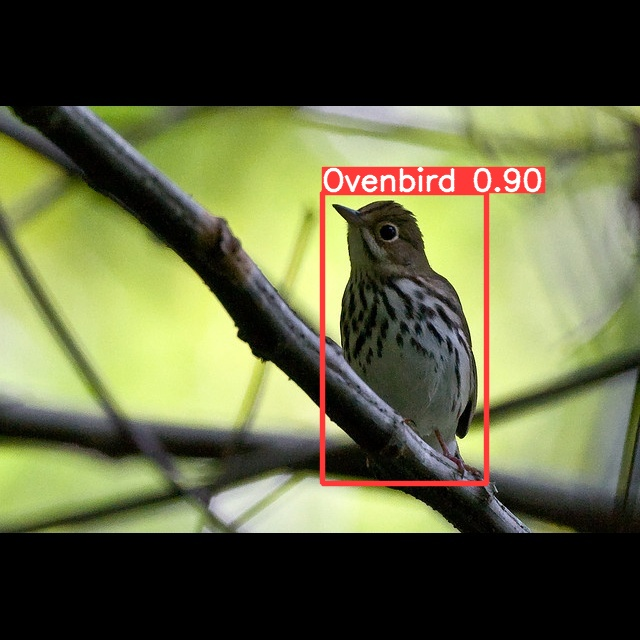

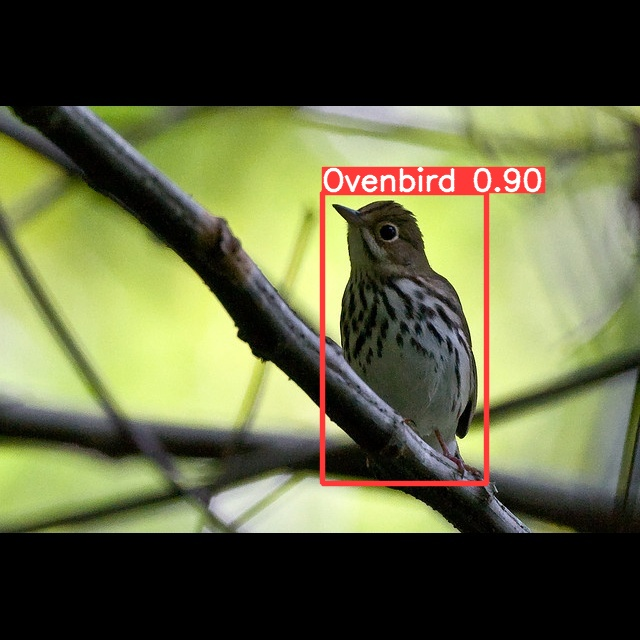

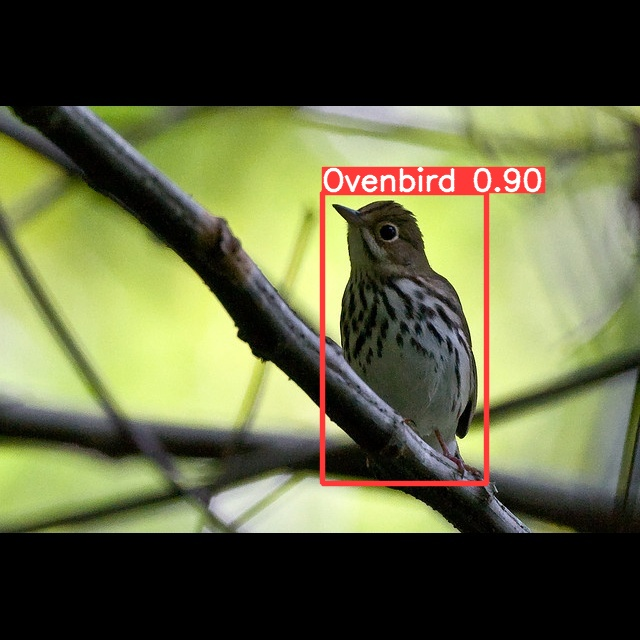

In [ ]:
# ==== YOLOv9 (DUAL) inference with class names & CSV ====
import os, glob, csv
from pathlib import Path
from IPython.display import display, Image

# Paths
BASE_OUT = globals().get("BASE_OUT", "/content/output")
REPO_DIR = f"{BASE_OUT}/yolov9"
WEIGHTS  = f"{BASE_OUT}/y9_runs/coco_y9m_ep100_b32/weights/best.pt"  # adjust if needed
DATA_YAML_PATH = globals().get("DATA_YAML", "/content/output/data.yaml")
INFER_IN  = "/content/input/infer"
INFER_OUT = f"{BASE_OUT}/y9_infer"
RUN_NAME  = "run_classes_dual"

os.makedirs(INFER_IN, exist_ok=True)
os.makedirs(INFER_OUT, exist_ok=True)

# Ensure we have the dual detect script
dual_script = Path(REPO_DIR) / "detect_dual.py"
if not dual_script.exists():
    raise FileNotFoundError(
        f"{dual_script} not found. You trained/validated with *_dual.py, "
        "so you need detect_dual.py. Do: %cd {REPO_DIR} && git pull"
    )

# Pillow pin to avoid plot font API break
!pip -q install "Pillow<10" pyyaml >/dev/null

# Upload images directly into INFER_IN
from google.colab import files
print("Upload one or more image files:")
uploaded = files.upload()
for fname, data in uploaded.items():
    p = Path(INFER_IN) / Path(fname).name
    with open(p, "wb") as f:
        f.write(data)
print(f"Saved {len(uploaded)} file(s) to {INFER_IN}")

# Inference knobs
IMG = 640
CONF = 0.25
IOU  = 0.45
DEV  = 0

# Run dual detect (this script handles dual-head outputs)
%cd {REPO_DIR}
!python detect_dual.py \
  --weights "{WEIGHTS}" \
  --img {IMG} \
  --conf {CONF} \
  --iou {IOU} \
  --device {DEV} \
  --source "{INFER_IN}" \
  --project "{INFER_OUT}" \
  --name "{RUN_NAME}" \
  --exist-ok \
  --save-txt --save-conf

# Parse labels -> class names + CSV
import yaml
from collections import Counter

result_dir = Path(INFER_OUT) / RUN_NAME
labels_dir = result_dir / "labels"

# Load your class names (1011 of them)
with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)
names = data_cfg.get("names", [])
if isinstance(names, dict):
    names = [names[i] for i in sorted(names.keys(), key=lambda x: int(x))]

rows = []
per_image_counts = {}
if labels_dir.exists():
    for txt in sorted(labels_dir.glob("*.txt")):
        stem = txt.stem
        img_name = None
        for ext in (".jpg",".png",".jpeg",".webp",".bmp"):
            q = result_dir / f"{stem}{ext}"
            if q.exists():
                img_name = q.name
                break
        if img_name is None:
            img_name = stem

        with open(txt, "r") as f:
            dets = [line.strip().split() for line in f if line.strip()]
        cnt = Counter()
        for d in dets:
            # format: cls xc yc w h conf
            if len(d) < 6:
                cls_id, xc, yc, w, h = d[:5]; conf = ""
            else:
                cls_id, xc, yc, w, h, conf = d[:6]
            cls_id = int(float(cls_id))
            cls_name = names[cls_id] if 0 <= cls_id < len(names) else str(cls_id)
            cnt[cls_name] += 1
            rows.append([img_name, cls_id, cls_name, conf, xc, yc, w, h])
        per_image_counts[img_name] = cnt

csv_path = result_dir / "detections.csv"
if rows:
    import csv
    with open(csv_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["image","class_id","class_name","conf","x_center","y_center","width","height"])
        w.writerows(rows)
    print(f"\nDetections CSV saved to: {csv_path}")
else:
    print("\nNo detections saved. (Maybe no objects above conf threshold.)")

# Print class names per image
if per_image_counts:
    print("\nPredicted classes per image:")
    for img, cnt in per_image_counts.items():
        top = ", ".join([f"{k}×{v}" for k, v in cnt.most_common()[:50]])
        print(f"  - {img}: {top if top else 'no detections'}")

# Show annotated images
imgs = sorted(glob.glob(f"{result_dir}/*.jpg")) + \
       sorted(glob.glob(f"{result_dir}/*.png")) + \
       sorted(glob.glob(f"{result_dir}/*.jpeg"))
print(f"\nAnnotated images in: {result_dir}")
for p in imgs[:24]:
    display(Image(filename=p))
if len(imgs) > 24:
    print(f"... and {len(imgs)-24} more images in the folder.")


# YOLO V9 KAGGLE

In [ ]:
# ================== CONFIG (uses your existing split) ==================
ROOT = "/kaggle/input/dataset-with-coco/dataset"

CSV = {
    "train": f"{ROOT}/annotations/train_annotations.csv",
    "val":   f"{ROOT}/annotations/valid_annotations.csv",
    "test":  f"{ROOT}/annotations/test_annotations.csv",
}
IMGS_SRC = {
    "train": f"{ROOT}/images/train",
    "val":   f"{ROOT}/images/valid",
    "test":  f"{ROOT}/images/test",
}
COCO_JSON = {
    "train": f"{ROOT}/coco-files/COCOtrain.json",
    "val":   f"{ROOT}/coco-files/COCOvalid.json",
    "test":  f"{ROOT}/coco-files/COCOtest.json",
}
CLASSES_TXT = "/kaggle/input/dataset-with-coco/classes.txt"

WORK = "/kaggle/working/coco_yolo"      # YOLO-ready mirror (writable)
IMGS = {k: f"{WORK}/images/{k}" for k in ("train","val","test")}
LABS = {k: f"{WORK}/labels/{k}" for k in ("train","val","test")}
DATA_YAML = "/kaggle/working/data.yaml"
# ======================================================================

import os, json, shutil, glob
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# fresh folders
for d in [WORK] + list(IMGS.values()) + list(LABS.values()):
    shutil.rmtree(d, ignore_errors=True)
    os.makedirs(d, exist_ok=True)

# --- class id mapping (CSV class_id -> 0..nc-1) ---
orig_ids, names = [], []
with open(CLASSES_TXT, "r", encoding="utf-8") as f:
    for ln in f:
        ln = ln.strip()
        if not ln: continue
        cid_str, cname = (ln.split(" ", 1) + [""])[:2]
        orig_ids.append(int(cid_str))
        names.append(cname if cname else cid_str)
orig_sorted = sorted(orig_ids)
id2idx = {cid:i for i,cid in enumerate(orig_sorted)}
names_sorted = [names[orig_ids.index(cid)] for cid in orig_sorted]
nc = len(names_sorted)
print(f"Classes: nc={nc}")

# --- link (or copy if symlink blocked) images into the mirror tree ---
def link_or_copy(src, dst):
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        os.symlink(src, dst)
    except OSError:
        shutil.copy2(src, dst)

def mirror_images(src_root, dst_root, desc):
    src_root = Path(src_root)
    files = [p for p in src_root.rglob("*") if p.is_file()]
    for p in tqdm(files, desc=f"mirror {desc}", unit="it"):
        rel = p.relative_to(src_root)
        link_or_copy(str(p), Path(dst_root)/rel)

for split in ("train","val","test"):
    mirror_images(IMGS_SRC[split], IMGS[split], split)

# quick index: basename -> mirrored path
def build_path_index(mirror_root):
    idx = {}
    for p in Path(mirror_root).rglob("*"):
        if p.is_file():
            idx.setdefault(p.name, p)
    return idx

path_idx = {s: build_path_index(IMGS[s]) for s in ("train","val","test")}
print("Path index ready.")

# load width/height from COCO JSON (fast)
def load_sizes_from_coco(json_path):
    with open(json_path, "r") as f:
        coco = json.load(f)
    return {Path(im["file_name"]).name: (int(im["width"]), int(im["height"]))
            for im in coco.get("images", [])}

sizes = {s: load_sizes_from_coco(COCO_JSON[s]) for s in ("train","val","test")}
print("Loaded W/H maps from COCO JSONs.")

# CSV -> YOLO labels (vectorized, fast)
def csv_to_yolo_fast(csv_path, split, mirror_root, labels_root):
    df = pd.read_csv(csv_path)
    cols = {c.lower(): c for c in df.columns}
    need = ["image_name","class_id","x","y","width","height"]
    for k in need:
        if k not in cols: raise ValueError(f"{csv_path} missing column '{k}'")
    df = df.rename(columns=cols).copy()
    df["base"] = df["image_name"].astype(str).apply(lambda p: Path(p).name)

    # add W,H from COCO json (skip rows not present)
    wh = df["base"].map(lambda b: sizes[split].get(b, (np.nan, np.nan)))
    df["W"] = [w for (w, _) in wh]
    df["H"] = [h for (_, h) in wh]
    df = df.dropna(subset=["W","H"])

    # normalize tlwh -> xywh (centered)
    df["xc"] = (df["x"] + df["width"]/2) / df["W"]
    df["yc"] = (df["y"] + df["height"]/2) / df["H"]
    df["wn"] = df["width"] / df["W"]
    df["hn"] = df["height"] / df["H"]
    for c in ["xc","yc","wn","hn"]:
        df[c] = df[c].clip(0.0, 1.0)

    # map classes
    df["yolo_cls"] = df["class_id"].map(id2idx)
    df = df.dropna(subset=["yolo_cls"])
    df["yolo_cls"] = df["yolo_cls"].astype(int)

    # write files grouped per image
    n_imgs, n_boxes = 0, 0
    for base, g in tqdm(df.groupby("base"), desc=f"labels {Path(csv_path).name}"):
        img_path = path_idx[split].get(base)
        if img_path is None:
            continue
        rel = Path(img_path).relative_to(Path(mirror_root))
        out_lbl = Path(labels_root)/rel.with_suffix(".txt")
        out_lbl.parent.mkdir(parents=True, exist_ok=True)
        lines = g.apply(lambda r: f"{int(r.yolo_cls)} {r.xc:.6f} {r.yc:.6f} {r.wn:.6f} {r.hn:.6f}", axis=1)
        out_lbl.write_text("\n".join(lines.tolist()))
        n_imgs += 1
        n_boxes += len(g)
    return n_imgs, n_boxes

stats = {}
for split in ("train","val","test"):
    nimg, nbox = csv_to_yolo_fast(CSV[split], split, IMGS[split], LABS[split])
    stats[split] = (nimg, nbox)
    print(f"{split}: wrote {nbox} boxes across {nimg} images")

assert stats["train"][1] > 0, "No boxes in train — check CSV ids and COCO sizes."

# data.yaml
with open(DATA_YAML, "w", encoding="utf-8") as f:
    f.write(f"train: {IMGS['train']}\n")
    f.write(f"val:   {IMGS['val']}\n")
    f.write(f"test:  {IMGS['test']}\n")
    f.write(f"nc: {nc}\n")
    f.write(f"names: {names_sorted}\n")
print("Wrote", DATA_YAML)

# remove any stale YOLO caches
for split in ("train","val","test"):
    cf = f"{LABS[split]}.cache"
    if os.path.exists(cf):
        os.remove(cf)
        print("Removed stale cache:", cf)

In [ ]:
# Clean clone (avoid nested folders)
%cd /kaggle/working
!git clone -q https://github.com/WongKinYiu/yolov9.git
%cd /kaggle/working/yolov9
!pip -q install -r requirements.txt

# Pretrained yolov9-m
!wget -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m.pt -O /kaggle/working/yolov9-m.pt


In [ ]:
# Runtime env (quiet W&B, reduce CUDA fragmentation)
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
# Train (keeps your usual flags; workers=0; cache=ram; patience=50)
%cd /kaggle/working/yolov9
!python train_dual.py \
  --img 640 \
  --batch -1 \
  --epochs 100 \
  --data /kaggle/working/data.yaml \
  --cfg models/detect/yolov9-m.yaml \
  --weights /kaggle/working/yolov9-m.pt \
  --device 0 \
  --workers 0 \
  --rect \
  --cache ram \
  --project /kaggle/working/y9_runs \
  --name coco_y9m_ep100 --exist-ok \
  --hyp data/hyps/hyp.scratch-high.yaml \
  --patience 50 \
  --noplots


In [ ]:
!python val_dual.py \
  --weights /kaggle/working/y9_runs/coco_y9m_ep100/weights/best.pt \
  --data /kaggle/working/data.yaml \
  --task test \
  --img 640 --batch -1 \
  --device 0 --workers 0 \
  --project /kaggle/working/y9_runs \
  --name coco_y9m_ep100_test --exist-ok


# NEW ATTEMPT ABOVE ^

In [ ]:
# # ====== CONFIG ======
# DATA_DIR   = "/kaggle/input/nabirds-preprocessed/nabirds_preprocessed"
# IMAGES_SRC = f"{DATA_DIR}/images"
# OUTPUT_DIR = "/kaggle/working/nabirds_yolo"
# SPLIT_SEED = 42
# TRAIN_PCT, VAL_PCT, TEST_PCT = 0.70, 0.15, 0.15  # per-class 70/20/10
# # ====================

# import os, math, random, shutil, glob
# from pathlib import Path
# from collections import defaultdict
# import pandas as pd
# from PIL import Image

# random.seed(SPLIT_SEED)

# # 1) Parse classes.txt (robust to spaces/commas in names)
# cls_ids, cls_names = [], []
# with open(f"{DATA_DIR}/classes.txt", "r", encoding="utf-8") as f:
#     for line in f:
#         line = line.strip()
#         if not line:
#             continue
#         parts = line.split(" ", 1)
#         if len(parts) != 2:
#             continue
#         cid = int(parts[0])
#         cname = parts[1].strip()
#         cls_ids.append(cid)
#         cls_names.append(cname)

# classes_df   = pd.DataFrame({"orig_id": cls_ids, "class_name": cls_names})
# unique_orig  = sorted(classes_df["orig_id"].tolist())
# orig_to_yolo = {orig: i for i, orig in enumerate(unique_orig)}
# yolo_names   = [classes_df.set_index("orig_id").loc[orig, "class_name"] for orig in unique_orig]
# NC = len(yolo_names)
# print(f"Loaded {NC} classes. Example:", list(zip(unique_orig[:5], yolo_names[:5])))

# # 2) Read annotations (top-left x,y + width,height)
# ann = pd.read_csv(f"{DATA_DIR}/annotations_all.csv")
# req = {"image_id","class_id","image_name","x","y","width","height"}
# missing = req - set(ann.columns)
# if missing:
#     raise ValueError(f"annotations_all.csv missing columns: {missing}")

# # group per image
# from collections import defaultdict
# img_rows = defaultdict(list)
# for r in ann.itertuples(index=False):
#     img_rows[r.image_id].append(r)

# # keep images that exist
# def exists_image(image_name):
#     return os.path.exists(os.path.join(IMAGES_SRC, image_name))

# img_rows = {iid: rows for iid, rows in img_rows.items() if exists_image(rows[0].image_name)}
# print(f"Images with existing files & annotations: {len(img_rows)}")

# # per-class -> image ids
# class_to_images = defaultdict(list)
# for iid, rows in img_rows.items():
#     cid = int(rows[0].class_id)
#     class_to_images[cid].append(iid)

# # 3) Make output dirs
# for split in ["train","val","test"]:
#     Path(f"{OUTPUT_DIR}/images/{split}").mkdir(parents=True, exist_ok=True)
#     Path(f"{OUTPUT_DIR}/labels/{split}").mkdir(parents=True, exist_ok=True)

# # 4) Stratified split per class (70/20/10)
# image_to_split = {}
# for cid, ids in class_to_images.items():
#     ids = sorted(set(ids))  # stable
#     random.shuffle(ids)
#     n = len(ids)
#     n_train = int(math.floor(TRAIN_PCT * n))
#     n_val   = int(math.floor(VAL_PCT   * n))
#     # put any rounding remainder into test
#     n_test  = n - n_train - n_val

#     train_ids = ids[:n_train]
#     val_ids   = ids[n_train:n_train+n_val]
#     test_ids  = ids[n_train+n_val:]

#     for iid in train_ids: image_to_split[iid] = "train"
#     for iid in val_ids:   image_to_split[iid] = "val"
#     for iid in test_ids:  image_to_split[iid] = "test"

# # 5) Copy & convert labels to YOLO
# copied, missing = 0, 0
# for iid, rows in img_rows.items():
#     split = image_to_split.get(iid, "train")
#     src_rel = rows[0].image_name  # e.g. "0817/xxxx.jpg"
#     src_path = os.path.join(IMAGES_SRC, src_rel)
#     if not os.path.exists(src_path):
#         missing += 1
#         continue

#     try:
#         with Image.open(src_path) as im:
#             W, H = im.size
#     except Exception:
#         missing += 1
#         continue

#     # all boxes for this image
#     lines = []
#     for r in rows:
#         x, y, w, h = float(r.x), float(r.y), float(r.width), float(r.height)
#         xc = (x + w/2.0) / W
#         yc = (y + h/2.0) / H
#         wn = w / W
#         hn = h / H
#         xc = min(max(xc,0.0),1.0); yc = min(max(yc,0.0),1.0)
#         wn = min(max(wn,0.0),1.0); hn = min(max(hn,0.0),1.0)
#         yolo_cls = orig_to_yolo[int(r.class_id)]
#         lines.append(f"{yolo_cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

#     # use image_id to avoid name collisions; keep .jpg extension
#     dst_img = os.path.join(OUTPUT_DIR, "images", split, f"{iid}.jpg")
#     dst_lbl = os.path.join(OUTPUT_DIR, "labels", split, f"{iid}.txt")
#     shutil.copy(src_path, dst_img)
#     with open(dst_lbl, "w") as f:
#         f.write("\n".join(lines))
#     copied += 1

# print(f"✅ Conversion + split done. Copied: {copied}, Skipped/Missing: {missing}")

# # 6) Save split index & quick counts
# split_df = pd.DataFrame({"image_id": list(image_to_split.keys()),
#                          "split": [image_to_split[i] for i in image_to_split.keys()]})
# split_df.to_csv("/kaggle/working/nabirds_split_70_15_15.csv", index=False)
# print("Split CSV -> /kaggle/working/nabirds_split_70_15_15.csv")

# def count_split(split):
#     return len(glob.glob(f"{OUTPUT_DIR}/images/{split}/*.jpg"))
# print("Counts -> train:", count_split("train"),
#       "val:", count_split("val"),
#       "test:", count_split("test"))

# # 7) data.yaml (now includes test path)
# yaml_path = "/kaggle/working/data.yaml"
# with open(yaml_path, "w", encoding="utf-8") as f:
#     f.write(f"train: {OUTPUT_DIR}/images/train\n")
#     f.write(f"val: {OUTPUT_DIR}/images/val\n")
#     f.write(f"test: {OUTPUT_DIR}/images/test\n")
#     f.write(f"nc: {NC}\n")
#     f.write(f"names: {yolo_names}\n")
# print("data.yaml ->", yaml_path)


In [ ]:

# print("cuda available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("device:", torch.cuda.get_device_name(0))


In [ ]:
# # Get YOLOv9 code
# !git clone -q https://github.com/WongKinYiu/yolov9.git
# %cd /kaggle/working/yolov9
# !pip install -q -r requirements.txt

# # Get YOLOv9-M pretrained weights
# !wget -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m.pt -O /kaggle/working/yolov9-m.pt

# # Quiet W&B + reduce CUDA fragmentation
# import os
# os.environ["WANDB_DISABLED"] = "true"
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# # If batch=16 OOMs, keep batch=-1 to auto-fit. You asked for 100 epochs, 640 imgsz.
# !python train_dual.py \
#   --img 640 \
#   --batch -1 \
#   --epochs 100 \
#   --data /kaggle/working/data.yaml \
#   --cfg models/detect/yolov9-m.yaml \
#   --weights /kaggle/working/yolov9-m.pt \
#   --device 0 \
#   --workers 2 \
#   --rect \
#   --cache disk \
#   --project /kaggle/working/y9_runs \
#   --name nabirds_y9m_ft_ep100 --exist-ok

In [ ]:
# %cd /kaggle/working/yolov9
# !python train_dual.py \
#   --resume /kaggle/working/y9_runs/nabirds_y9m_ft_ep100/weights/last.pt \
#   --device 0 \
#   --workers 2

In [ ]:
# !python val_dual.py \
#   --weights /kaggle/working/y9_runs/nabirds_y9m_ft_ep100/weights/best.pt \
#   --data /kaggle/working/data.yaml \
#   --task test \
#   --img 640 --batch -1 \
#   --device 0 --workers 2 \
#   --project /kaggle/working/y9_runs \
#   --name nabirds_y9m_test --exist-ok


# YOLO V8

In [ ]:
# import os, shutil, random
# from pathlib import Path
# import cv2
# import numpy as np

# # CONFIG
# SRC_DIR   = "/kaggle/input/nabirds-preprocessed/nabirds_preprocessed/images"
# DEST_DIR  = "/kaggle/working/nabirds_split"
# TRAIN_PCT, VAL_PCT, TEST_PCT = 0.70, 0.15, 0.15
# SEED = 42
# CHECK_IMAGES = True   # set False to skip broken image check

# random.seed(SEED)

# # 1. Make folders
# for split in ["train", "val", "test"]:
#     Path(f"{DEST_DIR}/{split}").mkdir(parents=True, exist_ok=True)

# # 2. Split per class
# for class_name in sorted(os.listdir(SRC_DIR)):
#     class_path = os.path.join(SRC_DIR, class_name)
#     if not os.path.isdir(class_path):
#         continue

#     images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg",".png"))]
#     random.shuffle(images)

#     n = len(images)
#     n_train = int(TRAIN_PCT * n)
#     n_val   = int(VAL_PCT   * n)
#     n_test  = n - n_train - n_val

#     splits = {
#         "train": images[:n_train],
#         "val":   images[n_train:n_train+n_val],
#         "test":  images[n_train+n_val:]
#     }

#     for split, files in splits.items():
#         out_class_dir = os.path.join(DEST_DIR, split, class_name)
#         Path(out_class_dir).mkdir(parents=True, exist_ok=True)

#         for f in files:
#             shutil.copy(os.path.join(class_path, f),
#                         os.path.join(out_class_dir, f))

# print("✅ Split done.")

# # 3. Check for broken images (optional)
# if CHECK_IMAGES:
#     unused_dir = os.path.join(DEST_DIR, "unused_image")
#     Path(unused_dir).mkdir(exist_ok=True)

#     for split in ["train", "val", "test"]:
#         for class_name in os.listdir(os.path.join(DEST_DIR, split)):
#             class_dir = os.path.join(DEST_DIR, split, class_name)
#             for f in os.listdir(class_dir):
#                 path_file = os.path.join(class_dir, f)
#                 try:
#                     img = cv2.imdecode(np.fromfile(path_file, np.uint8), cv2.IMREAD_COLOR)
#                     if img is None:
#                         print("Corrupt:", path_file)
#                         shutil.move(path_file, os.path.join(unused_dir, f))
#                 except Exception as e:
#                     print("Error:", path_file, e)
#                     shutil.move(path_file, os.path.join(unused_dir, f))

#     print("✅ Broken image check done.")

In [ ]:
# # Install YOLOv8
# %pip install ultralytics

# import ultralytics
# ultralytics.checks()

In [ ]:
# # Train classifier
# !yolo classify train \
#   model=yolov8l-cls.pt \
#   data=/kaggle/working/nabirds_split \
#   imgsz=224 \
#   workers=8 \
#   batch=16 \
#   device=0 \
#   epochs=100 \
#   patience=50 \
#   name=yolov8_nabirds_cls

In [ ]:
# !yolo classify train \
#   model=runs/classify/yolov8_nabirds_cls/weights/last.pt \
#   resume=True

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from pathlib import Path

# # Path to your training run
# train_run = Path("runs/classify/yolov8_nabirds_cls")  # change if your run name differs
# csv_path = train_run / "results.csv"

# df = pd.read_csv(csv_path)
# epochs = range(1, len(df) + 1)

# # ---- Loss ----
# plt.figure(figsize=(7,4))
# for col in ["train/loss", "val/loss"]:
#     if col in df.columns:
#         plt.plot(epochs, df[col], label=col, linewidth=2)
# plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training & Validation Loss")
# plt.grid(True); plt.legend(); plt.show()

# # ---- Accuracy ----
# plt.figure(figsize=(7,4))
# for col,label in [
#     ("metrics/accuracy_top1", "Top-1 Acc (val)"),
#     ("metrics/accuracy_top5", "Top-5 Acc (val)")
# ]:
#     if col in df.columns:
#         plt.plot(epochs, df[col], label=label, linewidth=2)
# plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy")
# plt.grid(True); plt.legend(); plt.show()


In [ ]:
# from ultralytics import YOLO

# # Load trained model
# model = YOLO("runs/classify/yolov8_nabirds_cls/weights/best.pt")

# # Evaluate on test set
# results = model.val(
#     data="/kaggle/working/nabirds_split",
#     split="test",
#     imgsz=224,
#     batch=16,
#     device=0
# )

# print(results)  # dict with accuracy, top5_acc, loss, etc.

# Previous YOLOv9 Attempt

In [ ]:
# # ===== YOLOv9 (dual-head) training =====
# !git clone https://github.com/WongKinYiu/yolov9.git -q
# %cd /kaggle/working/yolov9
# !pip install -r requirements.txt -q

# !pip install torch==2.5.1 torchvision==0.20.1 --extra-index-url https://download.pytorch.org/whl/cu124

In [ ]:
# import torch, torchvision, sys
# print("Torch:", torch.__version__, "TorchVision:", torchvision.__version__)
# print("CUDA available:", torch.cuda.is_available())


# import os
# os.environ["WANDB_DISABLED"] = "true"   # kill the W&B prompt

In [ ]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# os.environ["WANDB_DISABLED"] = "true"  # keep W&B quiet


# # %cd /kaggle/working/yolov9
# # !python train_dual.py \
# #   --img 512 \
# #   --batch 8 \
# #   --epochs 20 \
# #   --patience 5 \
# #   --data /kaggle/working/data.yaml \
# #   --cfg models/detect/yolov9-c.yaml \
# #   --weights /kaggle/working/yolov9-c.pt \
# #   --device 0 \
# #   --workers 2 \
# #   --rect \
# #   --cache disk \
# #   --close-mosaic 10 \
# #   --project /kaggle/working/y9_runs \
# #   --name nabirds_c_512_ep20_unfrozen --exist-ok

# %cd /kaggle/working/yolov9
# !python train_dual.py \
#   --img 640 \
#   --batch 2 \
#   --epochs 20 \
#   --patience 5 \
#   --data /kaggle/working/data.yaml \
#   --cfg models/detect/yolov9-c.yaml \
#   --weights /kaggle/working/yolov9-c.pt \
#   --device 0 \
#   --workers 0 \
#   --rect \
#   --cache disk \
#   --close-mosaic 10 \
#   --project /kaggle/working/y9_runs \
#   --name nabirds_c_512_ep20_unfrozen --exist-ok

In [ ]:
# !python val_dual.py \
#   --weights /kaggle/working/y9_runs/nabirds_c_512_ep20_unfrozen/weights/best.pt \
#   --data /kaggle/working/data.yaml \
#   --task test \
#   --img 512 --batch 8 \
#   --device 0 --workers 2 \
#   --project /kaggle/working/y9_runs \
#   --name nabirds_TEST_512 --exist-ok